In [1]:
%load_ext autoreload
%autoreload 2
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git-repos/floto-tavi-outcome-prediction


In [8]:
from copy import deepcopy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import SimpleITK as sitk
import raster_geometry as rg
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from src.utils import find_center_of_mass, plane_from_three_points, pts_from_mps

def crop_and_get_bbox(image_slice, shp):
    diff = np.array(image_slice.shape) - shp
    bbox = np.array([
        [int(diff[0]), int(diff[0]) +shp[0]], 
        [int(diff[1]), int(diff[1]) +shp[1]]
    ])
    return image_slice[bbox[0,0]:bbox[0,1],bbox[1,0]:bbox[1,1]], bbox

def compute_orthogonal_basis_from_normal_vector(normal):
    v = np.array([1, 0, 0])
    if np.allclose(v, normal) or np.allclose(v, -normal):
        v = np.array([0, 1, 0])
    u1 = np.cross(normal, v)
    u1 = u1 / np.linalg.norm(u1)
    u2 = np.cross(normal, u1)
    u2 = u2 / np.linalg.norm(u2)
    return u1, u2

def draw_spheres_from_physical_points(img_sitk, points, radius=2):
    x1, y1, z1 = img_sitk.GetSize()
    # img_np = sitk.GetArrayFromImage(img_sitk)
    img_np = np.zeros((z1, y1, x1))

    sphere = rg.sphere(2*radius, radius)
    for c, pt in enumerate(points):
        xidx, yidx, zidx = img_sitk.TransformPhysicalPointToIndex(pt)
        if xidx >= x1 or yidx >= y1 or zidx >= z1:
            continue
        if zidx < 0:
            zidx = z1 + zidx
        xidx1, xidx2 = max(xidx-radius, 0), min(xidx+radius, x1)
        yidx1, yidx2 = max(yidx-radius, 0), min(yidx+radius, y1)
        zidx1, zidx2 = max(zidx-radius, 0), min(zidx+radius, z1)
        _sphere = deepcopy(sphere)
        if xidx1 == 0:
            _sphere = _sphere[-zidx2:]
        if xidx2 == x1:
            _sphere = _sphere[:(zidx2 - zidx1)]
        if yidx1 == 0:
            _sphere = _sphere[:,-yidx2:]
        if yidx2 == x1:
            _sphere = _sphere[:,:(yidx2 - yidx1)]
        if zidx1 == 0:
            _sphere = _sphere[:,:,-xidx2:]
        if zidx2 == x1:
            _sphere = _sphere[:,:,:(xidx2 - xidx1)]
        img_np[zidx1:zidx2,yidx1:yidx2,xidx1:xidx2][_sphere > 0] = (_sphere * (c+1))[_sphere > 0]
    img_sitk_new = sitk.GetImageFromArray(img_np)
    img_sitk_new.CopyInformation(img_sitk)
    return img_sitk_new

def extract_slice_from_three_points(image_data, points):
    _, normal = plane_from_three_points(points)
    u1, u2 = compute_orthogonal_basis_from_normal_vector(normal)
    reslice = vtk.vtkImageReslice()
    reslice.SetResliceAxesDirectionCosines(u1.tolist(), u2.tolist(), normal.tolist())
    reslice.SetOutputDimensionality(2)
    reslice.SetResliceAxesOrigin(points[0].tolist())
    reslice.SetInputData(image_data)
    reslice.Update()
    output_slice = reslice.GetOutput()
    dims = output_slice.GetDimensions()
    flattened_image = vtk_to_numpy(output_slice.GetPointData().GetScalars())
    numpy_array = flattened_image.reshape(dims[2], dims[1], dims[0])
    return numpy_array[0]

def slice_with_three_points(fname, points):
    heart_sitk = sitk.ReadImage(fname)

    # heart_np = sitk.GetArrayFromImage(heart_sitk)
    
    points_px = [heart_sitk.TransformPhysicalPointToContinuousIndex(pt) for pt in points]
    heart_sitk.SetOrigin((0,0,0))
    points_vtk = np.array([heart_sitk.TransformContinuousIndexToPhysicalPoint(pt) for pt in points_px])
    # image_data.SetOrigin(heart_sitk.GetOrigin())
    seg_sitk_new = draw_spheres_from_physical_points(heart_sitk, points_vtk)

    sitk.WriteImage(seg_sitk_new, '__seg.nii.gz')
    image_reader = vtk.vtkNIFTIImageReader()
    image_reader.SetFileName(fname)
    image_reader.Update()
    image_data = image_reader.GetOutput()
    image_data.SetOrigin(heart_sitk.GetOrigin())
    seg_reader = vtk.vtkNIFTIImageReader()
    seg_reader.SetFileName('__seg.nii.gz')
    seg_reader.Update()
    seg_data = seg_reader.GetOutput()
    seg_data.SetOrigin(heart_sitk.GetOrigin())
    image_slice = extract_slice_from_three_points(image_data, points_vtk)
    seg_slice = extract_slice_from_three_points(seg_data, points_vtk)
    points_px = find_center_of_mass(seg_slice)
    return image_slice, points_px

In [9]:
pid = Path('/mnt/hdd/data/tavi_cts/TAVI CTs with Contrast Agent/1.3.46.670589.33.1.63647393450158616300001.5506677968494153299')
# pid = Path('/mnt/hdd/data/tavi_cts/TAVI CTs with Contrast Agent/1.3.46.670589.33.1.63647479663315706500001.5685812435824340730')
hps = pts_from_mps(pid / 'hps_new_origin.mps')
ms = pts_from_mps(pid / 'ms_new_origin.mps')
heart_roi_foc_fname = pid / 'tavi_heart_roi_foc.nii.gz'
heart_sitk = sitk.ReadImage(heart_roi_foc_fname)


In [10]:
from src.utils import focus_valve_region_from_pts, resample_image
heart_seg_fname = pid / 'heart_seg_new_origin.nii.gz'
calc_seg_fname = pid / 'calc_new_origin.nii.gz'
heart_seg = sitk.ReadImage(heart_seg_fname)
aorta_seg = sitk.GetArrayFromImage(heart_seg)
aorta_seg = (aorta_seg == 6).astype(np.float32)
aorta_seg = sitk.GetImageFromArray(aorta_seg)
aorta_seg.CopyInformation(heart_seg)
calc_seg = sitk.ReadImage(calc_seg_fname)
calc_seg = resample_image(calc_seg, out_spacing=heart_seg.GetSpacing())
heart_seg_foc = focus_valve_region_from_pts(heart_seg, pts=hps, step_mm=40)
aorta_seg_foc = focus_valve_region_from_pts(aorta_seg, pts=hps, step_mm=40)
calc_seg_foc = focus_valve_region_from_pts(calc_seg, pts=hps, step_mm=40)
heart_seg_foc_fname = pid / 'heart_seg_foc.nii.gz'
aorta_seg_foc_fname = pid / 'aorta_seg_foc.nii.gz'
calc_seg_foc_fname = pid / 'calc_seg_foc.nii.gz'
sitk.WriteImage(heart_seg_foc, heart_seg_foc_fname)
sitk.WriteImage(aorta_seg_foc, aorta_seg_foc_fname)
sitk.WriteImage(calc_seg_foc, calc_seg_foc_fname)

In [15]:
cp = sns.color_palette()
colors = {
    'RCC': cp[0],
    'LCC': cp[1],
    'ACC': cp[2],
    'RCA': cp[3],
    'LCA': cp[4],
    'MS1': cp[8],
    'MS2': cp[9]
}
seg_keys = ['Myo', 'LA', 'LV', 'RA', 'RV', 'Aorta', 'PA']
# seg_colors = [(0.5,0.5,0.5), (0.5,0.5,0.5),(0,1,0),(0.5,0.5,0.5),(0,0,1),(1,0,0),(0.5,0.5,0.5)]
seg_colors = ['purple', 'brown', 'green', 'pink', 'blue', 'red', 'olive']
seg_opacities = [0.6, 0.6, 0.3, 0.6, 0.6, 0.2, 0.6]

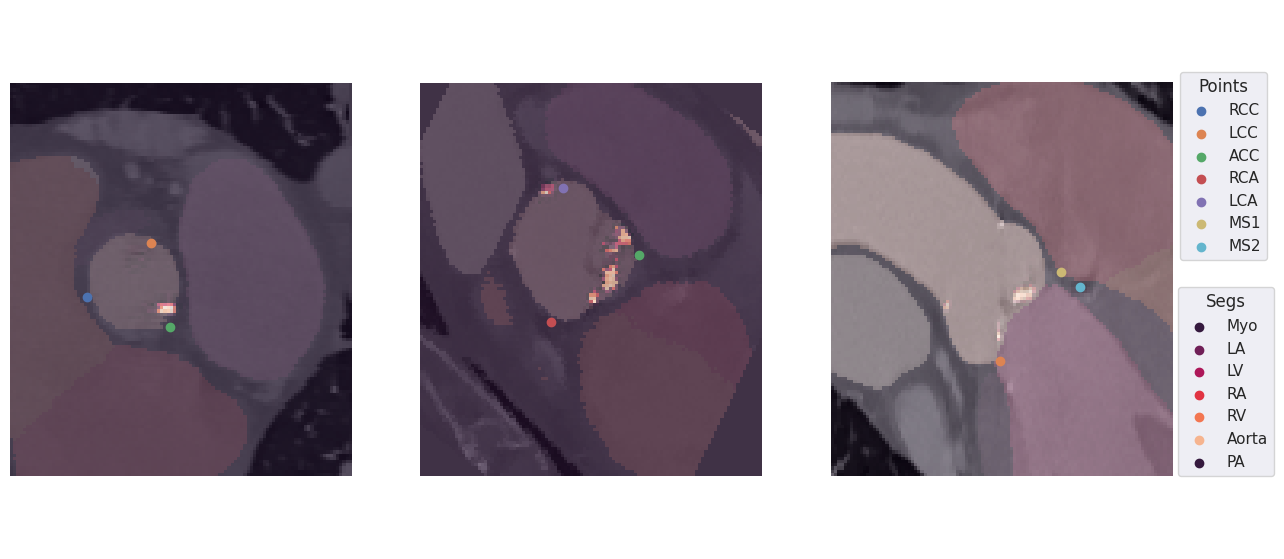

In [16]:
import matplotlib.colors as mcolors

image_slice_aa, points_px_aa = slice_with_three_points(heart_roi_foc_fname, hps[:3])
heart_slice_aa, _ = slice_with_three_points(heart_seg_foc_fname, hps[:3])
calc_slice_aa, _ = slice_with_three_points(calc_seg_foc_fname, hps[:3])
image_slice_ms, points_px_ms = slice_with_three_points(heart_roi_foc_fname, np.concatenate([ms, hps[1:2]], axis=0))
heart_slice_ms, _ = slice_with_three_points(heart_seg_foc_fname, np.concatenate([ms, hps[1:2]], axis=0))
calc_slice_ms, _ = slice_with_three_points(calc_seg_foc_fname, np.concatenate([ms, hps[1:2]], axis=0))
image_slice_ca, points_px_ca = slice_with_three_points(heart_roi_foc_fname, hps[2:])
heart_slice_ca, _ = slice_with_three_points(heart_seg_foc_fname, hps[2:])
calc_slice_ca, _ = slice_with_three_points(calc_seg_foc_fname, hps[2:])
shapes = np.array([image_slice_aa.shape, image_slice_ms.shape, image_slice_ca.shape])
min_dims = shapes.min(axis=0)
fig, axs = plt.subplots(1, 3, figsize=(15,7))
ax = axs[0]
image_slice_aa_cropped, bbox_aa = crop_and_get_bbox(image_slice_aa, min_dims)
heart_slice_aa_cropped, bbox_aa = crop_and_get_bbox(heart_slice_aa, min_dims)
heart_slice_aa_cropped[heart_slice_aa_cropped == 3] = 6
calc_slice_aa_cropped, bbox_aa = crop_and_get_bbox(calc_slice_aa, min_dims)
ax.imshow(image_slice_aa_cropped, cmap='gray')
# ax2 = ax.twinx()
# ax2.set_axis_off()
# for i, (l, c, o) in enumerate(zip(seg_keys, seg_colors, seg_opacities)):
#     seg = heart_slice_aa_cropped == (i+1)
#     cmap = mcolors.ListedColormap([(0,0,0), c])
#     ax2.imshow(seg, cmap=cmap, alpha=0.1)
ax.imshow(heart_slice_aa_cropped, alpha=0.2)
ax.imshow(calc_slice_aa_cropped, alpha=0.5)
ax.set_axis_off()
for pt, l in zip(points_px_aa, ['RCC', 'LCC', 'ACC']):
    ax.scatter([pt[1]-bbox_aa[1,0]], [pt[0]-bbox_aa[0,0]], label=l, color=colors[l])
ax = axs[1]
image_slice_ca_cropped, bbox_ca = crop_and_get_bbox(image_slice_ca, min_dims)
heart_slice_ca_cropped, bbox_ca = crop_and_get_bbox(heart_slice_ca, min_dims)
calc_slice_ca_cropped, bbox_ca = crop_and_get_bbox(calc_slice_ca, min_dims)
ax.imshow(image_slice_ca_cropped, cmap='gray')
ax.imshow(heart_slice_ca_cropped, alpha=0.2)
ax.imshow(calc_slice_ca_cropped, alpha=0.5)
ax.set_axis_off()
for pt, l in zip(points_px_ca, ['ACC', 'RCA', 'LCA']):
    ax.scatter([pt[1]-bbox_ca[1,0]], [pt[0]-bbox_ca[0,0]], label=l, color=colors[l])
ax = axs[2]
image_slice_ms_cropped, bbox_ms = crop_and_get_bbox(image_slice_ms, min_dims)
heart_slice_ms_cropped, bbox_ms = crop_and_get_bbox(heart_slice_ms, min_dims)
calc_slice_ms_cropped, bbox_ms = crop_and_get_bbox(calc_slice_ms, min_dims)
ax.imshow(image_slice_ms_cropped[::-1,::-1], cmap='gray')
ax.imshow(heart_slice_ms_cropped[::-1,::-1], alpha=0.2)
ax.imshow(calc_slice_ms_cropped[::-1,::-1], alpha=0.2)
ax.set_axis_off()
ax2 = ax.twinx()
ax2.set_axis_off()
shape_ms = image_slice_ms_cropped.shape
for pt, l in zip(points_px_ms, ['MS1', 'MS2', 'LCC']):
    ax.scatter([shape_ms[1]-(pt[1]-bbox_ms[1,0])], [shape_ms[0]-(pt[0]-bbox_ms[0,0])], color=colors[l])
    # ax.scatter([pt[1]-bbox_ms[1,0]], [pt[0]-bbox_ms[0,0]], color=colors[l])
xlim, ylim = ax.get_xlim(), ax.get_ylim()
for l, c in colors.items():
    ax.scatter([-1000],[-1000], label=l, color=c)
binary_cp = sns.color_palette('rocket')
for i, l in enumerate(seg_keys):
    ax2.scatter([-1000],[-1000], label=l, color=binary_cp[i % len(binary_cp)])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(bbox_to_anchor=[1.3,0.9], title='Points')
ax2.legend(bbox_to_anchor=[1.32,0.5], title='Segs')